In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression

from matplotlib import pyplot as plt

In [2]:
def evaluate_proxy_distribution_shift(x, y, theta_1, theta_2):
    n = x.shape[0]
    z_1 = np.matmul(x, theta_1) 
    z_2 = np.matmul(x, theta_2) 
    costs = (z_1-z_2)*(1-2*y)

    prc = LinearRegression(fit_intercept=False).fit(x, costs)  
    h_real = prc.predict(x)
    h_plus = h_real > 0
    h_minus = h_real < 0
    
    if np.abs(np.sum(costs[h_plus])) > np.abs(np.sum(costs[h_minus])):
        h = h_plus
    else:
        h = h_minus
    
    h = h.astype(int)    
       
    z_1_sum = np.sum(z_1)
    z_2_sum = np.sum(z_2)

    err_points = np.abs(h-y)

    err_cost_z_1 = np.squeeze(np.matmul(z_1.T, err_points))
    err_cost_z_2 = np.squeeze(np.matmul(z_2.T, err_points))
    overall_diff = z_1_sum/z_2_sum - 1
    model_diff = (err_cost_z_1 - err_cost_z_2)/n
    proxy_error = err_cost_z_1/z_1_sum - err_cost_z_2/z_2_sum
    coef_dist = scaled_coef_distance(theta_1,theta_2,x)/(np.mean(z_1)*np.mean(z_2))
    
    return overall_diff, model_diff, proxy_error, coef_dist

In [10]:
def scaled_coef_distance(theta_1, theta_2, x):
    outer_prod = np.outer(theta_1, theta_2)
    n = x.shape[0]
    coef_dist = []
    
    for m in range(n):
        dist=0
        prob_h = (n-m)/n
        for i in range(outer_prod.shape[0]):
            x_i = np.sort(x[:,i])
            c_i_plus = np.mean(x_i[m:])
            c_i_minus = np.mean(x_i[:(n-m)])
            for j in range(i):
                c_j = np.mean(x[:,j])
                dist+= c_j*(outer_prod[i,j] - outer_prod[j,i])
            if dist>0:
                dist=dist*c_i_plus*prob_h
            else:
                dist=dist*c_i_minus*prob_h
        coef_dist.append(dist)
        
    return np.max(coef_dist)

In [4]:
def synthetic_distribution_shift_experiments(trials, n, d, unit=False):
    #Add intercept
    intercept = np.ones(n).reshape(-1,1)
           
    discrepancy_total = []
    discrepancy_h = []
    discrepancy_proxy = []
    coef_dist = []
    for i in range(0,trials):
        np.random.seed(i)
        y = np.round(np.random.rand(n,1))
        
        theta_1 = np.random.rand(d,1)
        theta_1 = theta_1/np.linalg.norm(theta_1)
        
        theta_2 = np.random.rand(d,1)
        theta_2 = theta_2/np.linalg.norm(theta_2)
        
        x = np.random.rand(n,d)
        if unit:
            for j in range(0,n):
                x[j,:] = x[j,:]/np.linalg.norm(x[j,:])
                
        overall_diff, model_diff, proxy_error, c_dist = evaluate_proxy_distribution_shift(x,y,theta_1,theta_2)
       
        discrepancy_total.append(overall_diff)
        discrepancy_h.append(model_diff)
        discrepancy_proxy.append(proxy_error)
        coef_dist.append(c_dist)
        
    return discrepancy_total, discrepancy_h, discrepancy_proxy, coef_dist

In [ ]:
d_t, d_h, d_p, d_c = synthetic_distribution_shift_experiments(100,10,10, unit=False)

(array([ 2., 14., 22., 24., 17., 17.,  1.,  2.,  0.,  1.]),
 array([-0.17359366, -0.12377284, -0.07395203, -0.02413122,  0.02568959,
         0.07551041,  0.12533122,  0.17515203,  0.22497284,  0.27479366,
         0.32461447]),
 <BarContainer object of 10 artists>)

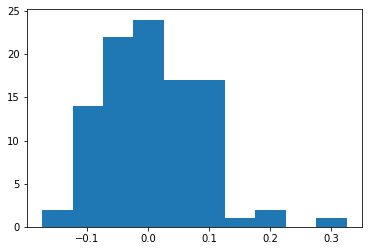

In [18]:
plt.hist(d_t)

(array([ 1.,  3.,  9., 24., 23., 14., 15.,  7.,  2.,  2.]),
 array([-0.15334353, -0.12022369, -0.08710385, -0.05398401, -0.02086416,
         0.01225568,  0.04537552,  0.07849536,  0.1116152 ,  0.14473505,
         0.17785489]),
 <BarContainer object of 10 artists>)

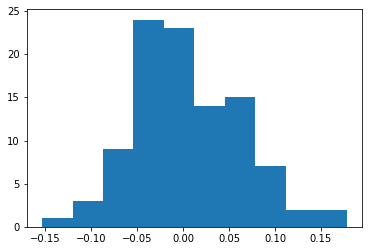

In [19]:
plt.hist(d_h)

(array([ 4., 10., 13.,  8., 10.,  6., 13., 20.,  9.,  7.]),
 array([-0.03021257, -0.02434857, -0.01848456, -0.01262056, -0.00675655,
        -0.00089255,  0.00497146,  0.01083547,  0.01669947,  0.02256348,
         0.02842748]),
 <BarContainer object of 10 artists>)

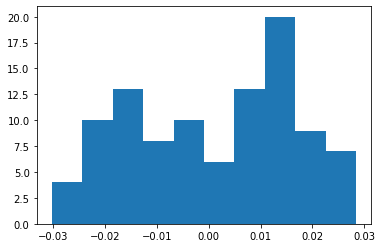

In [21]:
plt.hist(d_p)

(array([56.,  9.,  5.,  7.,  4.,  4.,  7.,  1.,  4.,  3.]),
 array([-4.30368831e-05,  1.80764832e-02,  3.61960032e-02,  5.43155232e-02,
         7.24350433e-02,  9.05545633e-02,  1.08674083e-01,  1.26793603e-01,
         1.44913123e-01,  1.63032644e-01,  1.81152164e-01]),
 <BarContainer object of 10 artists>)

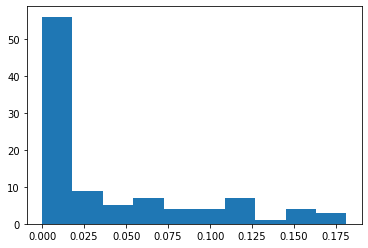

In [22]:
plt.hist(d_c)

(array([25., 22., 18., 11.,  1.,  8.,  7.,  5.,  2.,  1.]),
 array([-0.02842815, -0.00536548,  0.01769718,  0.04075985,  0.06382252,
         0.08688519,  0.10994786,  0.13301053,  0.15607319,  0.17913586,
         0.20219853]),
 <BarContainer object of 10 artists>)

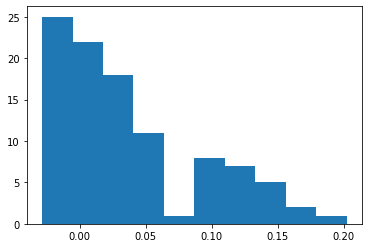

In [23]:
plt.hist(np.subtract(d_c,d_p))